In [168]:
import xarray as xr
import sys
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from matplotlib.offsetbox import AnnotationBbox
%matplotlib inline

In [169]:
sys.path.append('/workspace/bkraft/dl_chapter14/src')
from utils.plotting import plot_map, subplots_robinson, plot_hexbin, text_box, subplots_plateCarree
from utils.metrics import get_metrics

Added some useful functions, I will add more (e.g. plotting time-eries). Please don't change source code. You can also just use your own stuff or copy my functions and change them, or let me know if you want to have something changed.

## Load Data

In [170]:
#Spatially optimized
dss_nn = xr.open_zarr('/scratch/dl_chapter14/experiments/et/n_sm.n_perm/inference/pred_so.zarr/') *  86400 # 1 kg/m2/s = 86400 mm/day
dss_wn = xr.open_zarr('/scratch/dl_chapter14/experiments/et/w_sm.n_perm/inference/pred_so.zarr/') *  86400
dss_nw = xr.open_zarr('/scratch/dl_chapter14/experiments/et/n_sm.w_perm/inference/pred_so.zarr/') *  86400
dss_ww = xr.open_zarr('/scratch/dl_chapter14/experiments/et/w_sm.w_perm/inference/pred_so.zarr/') *  86400

#Temporally optimized
dst_nn = xr.open_zarr('/scratch/dl_chapter14/experiments/et/n_sm.n_perm/inference/pred_to.zarr/') *  86400
dst_wn = xr.open_zarr('/scratch/dl_chapter14/experiments/et/w_sm.n_perm/inference/pred_to.zarr/') *  86400
dst_nw = xr.open_zarr('/scratch/dl_chapter14/experiments/et/n_sm.w_perm/inference/pred_to.zarr/') *  86400
dst_ww = xr.open_zarr('/scratch/dl_chapter14/experiments/et/w_sm.w_perm/inference/pred_to.zarr/') *  86400

## Subset for the amazon region

In [172]:
amazon_mask = xr.open_dataset("/workspace/BGI/scratch/sbesnard/amazon_mask_360_720.nc").sel(lat= slice(10,-22), lon= slice(-85, -40))
amazon_raw_nn = dst_nn.sel(lat= slice(10,-22), lon= slice(-85, -40)) * amazon_mask.amazon_boundary
amazon_raw_nw = dst_nw.sel(lat= slice(10,-22), lon= slice(-85, -40)) * amazon_mask.amazon_boundary
amazon_raw_wn = dst_wn.sel(lat= slice(10,-22), lon= slice(-85, -40)) * amazon_mask.amazon_boundary
amazon_raw_ww = dst_ww.sel(lat= slice(10,-22), lon= slice(-85, -40)) * amazon_mask.amazon_boundary

## Subset for Australia

In [174]:
australia_raw_nn = dst_nn.sel(lat= slice(-10,-40), lon= slice(109, 156))
australia_raw_nw = dst_nw.sel(lat= slice(-10,-40), lon= slice(109, 156))
australia_raw_wn = dst_wn.sel(lat= slice(-10,-40), lon= slice(109, 156))
australia_raw_ww = dst_ww.sel(lat= slice(-10,-40), lon= slice(109, 156))

## Compute monthly seasonal cycle

In [175]:
#Amazon
amazon_seas_obs_2005 = amazon_raw_wn.sel(time=slice('2005-01-01', '2005-12-31')).obs.mean(('lat', 'lon')).groupby('time.month').mean('time')
amazon_seas_wn_2005 = amazon_raw_wn.sel(time=slice('2005-01-01', '2005-12-31')).mod.mean(('lat', 'lon')).groupby('time.month').mean('time')
amazon_seas_nn_2005 = amazon_raw_nn.sel(time=slice('2005-01-01', '2005-12-31')).mod.mean(('lat', 'lon')).groupby('time.month').mean('time')
amazon_seas_ww_2005 = amazon_raw_ww.sel(time=slice('2005-01-01', '2005-12-31')).mod.mean(('lat', 'lon')).groupby('time.month').mean('time')
amazon_seas_nw_2005 = amazon_raw_nw.sel(time=slice('2005-01-01', '2005-12-31')).mod.mean(('lat', 'lon')).groupby('time.month').mean('time')

In [176]:
#Australia
australia_seas_obs_2010 = australia_raw_wn.sel(time=slice('2010-01-01', '2010-12-31')).obs.mean(('lat', 'lon')).groupby('time.month').mean('time')
australia_seas_wn_2010 = australia_raw_wn.sel(time=slice('2010-01-01', '2010-12-31')).mod.mean(('lat', 'lon')).groupby('time.month').mean('time')
australia_seas_nn_2010 = australia_raw_nn.sel(time=slice('2010-01-01', '2010-12-31')).mod.mean(('lat', 'lon')).groupby('time.month').mean('time')
australia_seas_ww_2010 = australia_raw_ww.sel(time=slice('2010-01-01', '2010-12-31')).mod.mean(('lat', 'lon')).groupby('time.month').mean('time')
australia_seas_nw_2010 = australia_raw_nw.sel(time=slice('2010-01-01', '2010-12-31')).mod.mean(('lat', 'lon')).groupby('time.month').mean('time')

## Compute the residuals of the mean seasonal variations

In [177]:
# Amazon
amazon_seas_var_res_wn = (amazon_seas_obs_2005 - amazon_seas_obs_2005.mean('month')) - (amazon_seas_wn_2005 - amazon_seas_wn_2005.mean('month')) 
amazon_seas_var_res_nn = (amazon_seas_obs_2005 - amazon_seas_obs_2005.mean('month')) - (amazon_seas_nn_2005 - amazon_seas_nn_2005.mean('month')) 
amazon_seas_var_res_nw = (amazon_seas_obs_2005 - amazon_seas_obs_2005.mean('month')) - (amazon_seas_nw_2005 - amazon_seas_nw_2005.mean('month')) 
amazon_seas_var_res_ww = (amazon_seas_obs_2005 - amazon_seas_obs_2005.mean('month')) - (amazon_seas_ww_2005 - amazon_seas_ww_2005.mean('month')) 

In [178]:
# Australia
australia_seas_var_res_wn = (australia_seas_obs_2010 - australia_seas_obs_2010.mean('month')) - (australia_seas_wn_2010 - australia_seas_wn_2010.mean('month')) 
australia_seas_var_res_nn = (australia_seas_obs_2010 - australia_seas_obs_2010.mean('month')) - (australia_seas_nn_2010 - australia_seas_nn_2010.mean('month')) 
australia_seas_var_res_nw = (australia_seas_obs_2010 - australia_seas_obs_2010.mean('month')) - (australia_seas_nw_2010 - australia_seas_nw_2010.mean('month')) 
australia_seas_var_res_ww = (australia_seas_obs_2010 - australia_seas_obs_2010.mean('month')) - (australia_seas_ww_2010 - australia_seas_ww_2010.mean('month')) 

## Compute monthly anomalies

In [179]:
##Amazon

#Compute monthly mean 2000-2013
amazon_seas_obs = amazon_raw_wn.obs.mean(('lat', 'lon')).groupby('time.month').mean('time')
amazon_seas_wn = amazon_raw_wn.mod.mean(('lat', 'lon')).groupby('time.month').mean('time')
amazon_seas_nn = amazon_raw_nn.mod.mean(('lat', 'lon')).groupby('time.month').mean('time')
amazon_seas_ww = amazon_raw_ww.mod.mean(('lat', 'lon')).groupby('time.month').mean('time')
amazon_seas_nw = amazon_raw_nw.mod.mean(('lat', 'lon')).groupby('time.month').mean('time')

# Compute montly mean for 2005
amazon_seas_obs_2005 = amazon_raw_wn.obs.mean(('lat', 'lon')).resample(time = '1MS').mean().sel(time=slice('2005-01-01', '2005-12-31'))
amazon_seas_wn_2005 = amazon_raw_wn.mod.mean(('lat', 'lon')).resample(time = '1MS').mean().sel(time=slice('2005-01-01', '2005-12-31'))
amazon_seas_nn_2005 = amazon_raw_nn.mod.mean(('lat', 'lon')).resample(time = '1MS').mean().sel(time=slice('2005-01-01', '2005-12-31'))
amazon_seas_nw_2005 = amazon_raw_nw.mod.mean(('lat', 'lon')).resample(time = '1MS').mean().sel(time=slice('2005-01-01', '2005-12-31'))
amazon_seas_ww_2005 = amazon_raw_ww.mod.mean(('lat', 'lon')).resample(time = '1MS').mean().sel(time=slice('2005-01-01', '2005-12-31'))

# Compute montly anomalies
amazon_anom_obs_2005 = amazon_seas_obs_2005.values - amazon_seas_obs.values
amazon_anom_wn_2005 = amazon_seas_wn_2005.values - amazon_seas_wn.values
amazon_anom_nn_2005 = amazon_seas_nn_2005.values - amazon_seas_nn.values
amazon_anom_ww_2005 = amazon_seas_ww_2005.values - amazon_seas_ww.values
amazon_anom_nw_2005 = amazon_seas_nw_2005.values - amazon_seas_nw.values

In [180]:
##Amazon

#Compute monthly mean 2000-2013
australia_seas_obs = australia_raw_wn.obs.mean(('lat', 'lon')).groupby('time.month').mean('time')
australia_seas_wn = australia_raw_wn.mod.mean(('lat', 'lon')).groupby('time.month').mean('time')
australia_seas_nn = australia_raw_nn.mod.mean(('lat', 'lon')).groupby('time.month').mean('time')
australia_seas_ww = australia_raw_ww.mod.mean(('lat', 'lon')).groupby('time.month').mean('time')
australia_seas_nw = australia_raw_nw.mod.mean(('lat', 'lon')).groupby('time.month').mean('time')

# Compute montly mean for 2010
australia_seas_obs_2010 = australia_raw_wn.obs.mean(('lat', 'lon')).resample(time = '1MS').mean().sel(time=slice('2010-01-01', '2010-12-31'))
australia_seas_wn_2010 = australia_raw_wn.mod.mean(('lat', 'lon')).resample(time = '1MS').mean().sel(time=slice('2010-01-01', '2010-12-31'))
australia_seas_nn_2010 = australia_raw_nn.mod.mean(('lat', 'lon')).resample(time = '1MS').mean().sel(time=slice('2010-01-01', '2010-12-31'))
australia_seas_nw_2010 = australia_raw_nw.mod.mean(('lat', 'lon')).resample(time = '1MS').mean().sel(time=slice('2010-01-01', '2010-12-31'))
australia_seas_ww_2010 = australia_raw_ww.mod.mean(('lat', 'lon')).resample(time = '1MS').mean().sel(time=slice('2010-01-01', '2010-12-31'))

# Compute montly anomalies
australia_anom_obs_2010 = australia_seas_obs_2010.values - australia_seas_obs.values
australia_anom_wn_2010 = australia_seas_wn_2010.values - australia_seas_wn.values
australia_anom_nn_2010 = australia_seas_nn_2010.values - australia_seas_nn.values
australia_anom_ww_2010 = australia_seas_ww_2010.values - australia_seas_ww.values
australia_anom_nw_2010 = australia_seas_nw_2010.values - australia_seas_nw.values

## Compute annual anomalies (z-score)

In [182]:
##Amazon

# No permutation with soil moisture
amazon_raw_wn_annual = amazon_raw_wn.groupby('time.year').mean('time')
amazon_raw_wn_std = amazon_raw_wn.groupby('time.year').mean('time').std('year')
amazon_raw_wn_mean = amazon_raw_wn.groupby('time.year').mean('time').mean('year')
amazon_raw_wn_anomaly_standarise = (amazon_raw_wn_annual - amazon_raw_wn_mean) / amazon_raw_wn_std
amazon_raw_obs_anomaly_standarise_detrend = signal.detrend(amazon_raw_wn_anomaly_standarise.obs.mean(('lat', 'lon')))
amazon_raw_wn_anomaly_standarise_detrend = signal.detrend(amazon_raw_wn_anomaly_standarise.mod.mean(('lat', 'lon')))

# No permutation no soil moisture
amazon_raw_nn_annual = amazon_raw_nn.groupby('time.year').mean('time')
amazon_raw_nn_std = amazon_raw_nn.groupby('time.year').mean('time').std('year')
amazon_raw_nn_mean = amazon_raw_nn.groupby('time.year').mean('time').mean('year')
amazon_raw_nn_anomaly_standarise = (amazon_raw_nn_annual - amazon_raw_nn_mean) / amazon_raw_nn_std
amazon_raw_nn_anomaly_standarise_detrend = signal.detrend(amazon_raw_nn_anomaly_standarise.mod.mean(('lat', 'lon')))

# Permutation with soil moisture
amazon_raw_ww_annual = amazon_raw_ww.groupby('time.year').mean('time')
amazon_raw_ww_std = amazon_raw_ww.groupby('time.year').mean('time').std('year')
amazon_raw_ww_mean = amazon_raw_ww.groupby('time.year').mean('time').mean('year')
amazon_raw_ww_anomaly_standarise = (amazon_raw_ww_annual - amazon_raw_ww_mean) / amazon_raw_ww_std
amazon_raw_ww_anomaly_standarise_detrend = signal.detrend(amazon_raw_ww_anomaly_standarise.mod.mean(('lat', 'lon')))

# Permutation no soil moisture
amazon_raw_nw_annual = amazon_raw_nw.groupby('time.year').mean('time')
amazon_raw_nw_std = amazon_raw_nw.groupby('time.year').mean('time').std('year')
amazon_raw_nw_mean = amazon_raw_nw.groupby('time.year').mean('time').mean('year')
amazon_raw_nw_anomaly_standarise = (amazon_raw_nw_annual - amazon_raw_nw_mean) / amazon_raw_nw_std
amazon_raw_nw_anomaly_standarise_detrend = signal.detrend(amazon_raw_nw_anomaly_standarise.mod.mean(('lat', 'lon')))

/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [183]:
##Australia

# No permutation with soil moisture
australia_raw_wn_annual = australia_raw_wn.groupby('time.year').mean('time')
australia_raw_wn_std = australia_raw_wn.groupby('time.year').mean('time').std('year')
australia_raw_wn_mean = australia_raw_wn.groupby('time.year').mean('time').mean('year')
australia_raw_wn_anomaly_standarise = (australia_raw_wn_annual - australia_raw_wn_mean) / australia_raw_wn_std
australia_raw_obs_anomaly_standarise_detrend = signal.detrend(australia_raw_wn_anomaly_standarise.obs.mean(('lat', 'lon')))
australia_raw_wn_anomaly_standarise_detrend = signal.detrend(australia_raw_wn_anomaly_standarise.mod.mean(('lat', 'lon')))

# No permutation no soil moisture
australia_raw_nn_annual = australia_raw_nn.groupby('time.year').mean('time')
australia_raw_nn_std = australia_raw_nn.groupby('time.year').mean('time').std('year')
australia_raw_nn_mean = australia_raw_nn.groupby('time.year').mean('time').mean('year')
australia_raw_nn_anomaly_standarise = (australia_raw_nn_annual - australia_raw_nn_mean) / australia_raw_nn_std
australia_raw_nn_anomaly_standarise_detrend = signal.detrend(australia_raw_nn_anomaly_standarise.mod.mean(('lat', 'lon')))

# Permutation with soil moisture
australia_raw_ww_annual = australia_raw_ww.groupby('time.year').mean('time')
australia_raw_ww_std = australia_raw_ww.groupby('time.year').mean('time').std('year')
australia_raw_ww_mean = australia_raw_ww.groupby('time.year').mean('time').mean('year')
australia_raw_ww_anomaly_standarise = (australia_raw_ww_annual - australia_raw_ww_mean) / australia_raw_ww_std
australia_raw_ww_anomaly_standarise_detrend = signal.detrend(australia_raw_ww_anomaly_standarise.mod.mean(('lat', 'lon')))

# Permutation no soil moisture
australia_raw_nw_annual = australia_raw_nw.groupby('time.year').mean('time')
australia_raw_nw_std = australia_raw_nw.groupby('time.year').mean('time').std('year')
australia_raw_nw_mean = australia_raw_nw.groupby('time.year').mean('time').mean('year')
australia_raw_nw_anomaly_standarise = (australia_raw_nw_annual - australia_raw_nw_mean) / australia_raw_nw_std
australia_raw_nw_anomaly_standarise_detrend = signal.detrend(australia_raw_nw_anomaly_standarise.mod.mean(('lat', 'lon')))

/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


## Combine different scale into one numpy array

In [184]:
#Amazon
amazon_obs = {"seasonal_mean": amazon_seas_obs_2005, 'seasonal_anomaly':amazon_anom_obs_2005,
             "seasonal_res":np.zeros(10), 'annual_anomaly':amazon_raw_obs_anomaly_standarise_detrend}
amazon_wn = {"seasonal_mean": amazon_seas_wn_2005, 'seasonal_anomaly':amazon_anom_wn_2005,
             "seasonal_res":amazon_seas_var_res_wn, 'annual_anomaly':amazon_raw_wn_anomaly_standarise_detrend}
amazon_nn = {"seasonal_mean": amazon_seas_nn_2005, 'seasonal_anomaly':amazon_anom_nn_2005,
             "seasonal_res":amazon_seas_var_res_nn, 'annual_anomaly':amazon_raw_nn_anomaly_standarise_detrend}
amazon_ww = {"seasonal_mean": amazon_seas_ww_2005, 'seasonal_anomaly':amazon_anom_ww_2005,
             "seasonal_res":amazon_seas_var_res_ww, 'annual_anomaly':amazon_raw_ww_anomaly_standarise_detrend}
amazon_nw = {"seasonal_mean": amazon_seas_nw_2005, 'seasonal_anomaly':amazon_anom_nw_2005,
             "seasonal_res":amazon_seas_var_res_nw, 'annual_anomaly':amazon_raw_nw_anomaly_standarise_detrend}

In [185]:
#australia
australia_obs = {"seasonal_mean": australia_seas_obs_2010, 'seasonal_anomaly':australia_anom_obs_2010,
             "seasonal_res":np.zeros(10), 'annual_anomaly':australia_raw_obs_anomaly_standarise_detrend}
australia_wn = {"seasonal_mean": australia_seas_wn_2010, 'seasonal_anomaly':australia_anom_wn_2010,
             "seasonal_res":australia_seas_var_res_wn, 'annual_anomaly':australia_raw_wn_anomaly_standarise_detrend}
australia_nn = {"seasonal_mean": australia_seas_nn_2010, 'seasonal_anomaly':australia_anom_nn_2010,
             "seasonal_res":australia_seas_var_res_nn, 'annual_anomaly':australia_raw_nn_anomaly_standarise_detrend}
australia_ww = {"seasonal_mean": australia_seas_ww_2010, 'seasonal_anomaly':australia_anom_ww_2010,
             "seasonal_res":australia_seas_var_res_ww, 'annual_anomaly':australia_raw_ww_anomaly_standarise_detrend}
australia_nw = {"seasonal_mean": australia_seas_nw_2010, 'seasonal_anomaly':australia_anom_nw_2010,
             "seasonal_res":australia_seas_var_res_nw, 'annual_anomaly':australia_raw_nw_anomaly_standarise_detrend}

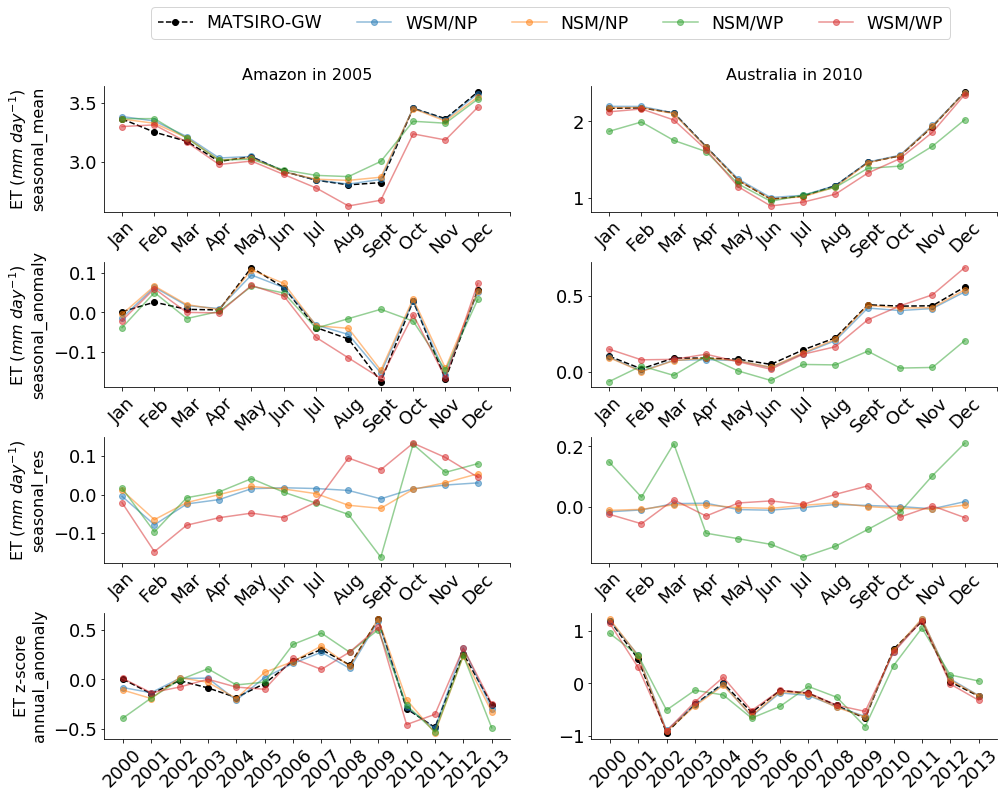

In [190]:
fig, ax = plt.subplots(4, 2, figsize=(16, 12), gridspec_kw={'wspace': 0.2, 'hspace': 0.4})
for i, var in enumerate(['seasonal_mean', 'seasonal_anomaly', 'seasonal_res', 'annual_anomaly']):
    #time = amazon_seas_ww_2005.time.values
    if var in ['seasonal_res']:
        # Amazom
        #ax[i, 0].fill_between(time, amazon_seas_obs_2005.isel(quantile=0), amazon_seas_obs_2005.isel(quantile=2), alpha=0.2, facecolor='tab:blue')
        ax[i, 0].plot(amazon_wn[var], alpha=0.5, label='WSM/NP', marker='o')
        ax[i, 0].plot(amazon_nn[var],  alpha=0.5, label='NSM/NP', marker='o')
        ax[i, 0].plot(amazon_nw[var], alpha=0.5, label='NSM/WP', marker='o')
        ax[i, 0].plot(amazon_ww[var], alpha=0.5, label='w/ SM\nw permutation', marker='o')
        ax[i, 0].spines['top'].set_visible(False)
        ax[i, 0].spines['right'].set_visible(False)
        
        # Australia
        ax[i, 1].plot(australia_wn[var], alpha=0.5, label='WSM/NP', marker='o')
        ax[i, 1].plot(australia_nn[var],  alpha=0.5, label='NSM/NP', marker='o')
        ax[i, 1].plot(australia_nw[var], alpha=0.5, label='NSM/WP', marker='o')
        ax[i, 1].plot(australia_ww[var], alpha=0.5, label='WSM/WP', marker='o')
        ax[i, 1].spines['top'].set_visible(False)
        ax[i, 1].spines['right'].set_visible(False)
    else:
        # Amazom
        #ax[i, 0].fill_between(time, amazon_seas_obs_2005.isel(quantile=0), amazon_seas_obs_2005.isel(quantile=2), alpha=0.2, facecolor='tab:blue')
        ax[i, 0].plot(amazon_obs[var],'k--', label='MATSIRO-GW', marker='o')
        ax[i, 0].plot(amazon_wn[var], alpha=0.5, label='WSM/NP', marker='o')
        ax[i, 0].plot(amazon_nn[var],  alpha=0.5, label='NSM/NP', marker='o')
        ax[i, 0].plot(amazon_nw[var], alpha=0.5, label='NSM/WP', marker='o')
        ax[i, 0].plot(amazon_ww[var], alpha=0.5, label='WSM/WP', marker='o')
        ax[i, 0].spines['top'].set_visible(False)
        ax[i, 0].spines['right'].set_visible(False)

        # Australia
        ax[i, 1].plot(australia_obs[var],'k--', label='MATSIRO-GW', marker='o')
        ax[i, 1].plot(australia_wn[var], alpha=0.5, label='WSM/NP', marker='o')
        ax[i, 1].plot(australia_nn[var],  alpha=0.5, label='NSM/NP', marker='o')
        ax[i, 1].plot(australia_nw[var], alpha=0.5, label='NSM/WP', marker='o')
        ax[i, 1].plot(australia_ww[var], alpha=0.5, label='WSM/WP', marker='o')
        ax[i, 1].spines['top'].set_visible(False)
        ax[i, 1].spines['right'].set_visible(False)
    if var == 'annual_anomaly':
        ax[i, 0].set_ylabel('ET z-score' + "\n" + var, size=16)
        ax[i, 1].set_ylabel('')
        ax[i, 0].set_xticks(np.arange(0, 14))
        ax[i, 0].set_xticklabels(['2000','2001', '2002', '2003', '2004', '2005', '2006', '2007', 
                                  '2008', '2009', '2010', '2011', '2012', '2013'],
                   rotation=45, fontsize=18)
        ax[i, 1].set_xticks(np.arange(0, 14))
        ax[i, 1].set_xticklabels(['2000','2001', '2002', '2003', '2004', '2005', '2006', '2007', 
                                  '2008', '2009', '2010', '2011', '2012', '2013'],
                   rotation=45, fontsize=18)
    else:
        ax[i, 0].set_ylabel('ET ($mm \ day^{-1}$)' + "\n" + var, size=16)
        ax[i, 1].set_ylabel('')
        ax[i, 0].set_xticks(np.arange(0, 13))
        ax[i, 0].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec'],
                   rotation=45, fontsize=18)
        ax[i, 1].set_xticks(np.arange(0, 13))
        ax[i, 1].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec'],
                   rotation=45, fontsize=18)
    ax[i, 0].tick_params(labelsize=18)
    ax[i, 1].tick_params(labelsize=18)
    ax[i, 0].yaxis.set_label_coords(-0.14,0.5)
ax[0, 0].set_title('Amazon in 2005', size=16)
ax[0, 1].set_title('Australia in 2010', size=16)
#ax[-2, 1].legend();
plt.legend(loc='upper center', bbox_to_anchor=(-0.1, 5.9),
          ncol=5, fancybox=True, fontsize=  'xx-large')
plt.gca().yaxis.set_label_position("right")
plt.savefig('/workspace/bkraft/dl_chapter14/src/notebooks/exp2_figures/Fig5.png', dpi=300)


## Compute difference of the annual anomalies

In [118]:
#Amazon
amazon_diff_obs_wn = amazon_raw_wn_anomaly_standarise.sel(year=2005).obs - amazon_raw_wn_anomaly_standarise.sel(year=2005).mod
amazon_diff_obs_wn.to_netcdf('/workspace/bkraft/dl_chapter14/src/amazon_diff_obs_wn.nc')
amazon_diff_obs_nn = amazon_raw_wn_anomaly_standarise.sel(year=2005).obs - amazon_raw_nn_anomaly_standarise.sel(year=2005).mod
amazon_diff_obs_nn.to_netcdf('/workspace/bkraft/dl_chapter14/src/amazon_diff_obs_nn.nc')
amazon_diff_obs_ww = amazon_raw_wn_anomaly_standarise.sel(year=2005).obs - amazon_raw_ww_anomaly_standarise.sel(year=2005).mod
amazon_diff_obs_ww.to_netcdf('/workspace/bkraft/dl_chapter14/src/amazon_diff_obs_ww.nc')
amazon_diff_obs_nw = amazon_raw_wn_anomaly_standarise.sel(year=2005).obs - amazon_raw_nw_anomaly_standarise.sel(year=2005).mod
amazon_diff_obs_nw.to_netcdf('/workspace/bkraft/dl_chapter14/src/amazon_diff_obs_nw.nc')


/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [123]:
#australia
australia_diff_obs_wn = australia_raw_wn_anomaly_standarise.sel(year=2010).obs - australia_raw_wn_anomaly_standarise.sel(year=2010).mod
australia_diff_obs_wn.to_netcdf('/workspace/bkraft/dl_chapter14/src/australia_diff_obs_wn.nc')
australia_diff_obs_nn = australia_raw_wn_anomaly_standarise.sel(year=2010).obs - australia_raw_nn_anomaly_standarise.sel(year=2010).mod
australia_diff_obs_nn.to_netcdf('/workspace/bkraft/dl_chapter14/src/australia_diff_obs_nn.nc')
australia_diff_obs_ww = australia_raw_wn_anomaly_standarise.sel(year=2010).obs - australia_raw_ww_anomaly_standarise.sel(year=2010).mod
australia_diff_obs_ww.to_netcdf('/workspace/bkraft/dl_chapter14/src/australia_diff_obs_ww.nc')
australia_diff_obs_nw = australia_raw_wn_anomaly_standarise.sel(year=2010).obs - australia_raw_nw_anomaly_standarise.sel(year=2010).mod
australia_diff_obs_nw.to_netcdf('/workspace/bkraft/dl_chapter14/src/australia_diff_obs_nw.nc')


/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [33]:
australia_diff_obs_wn 

<xarray.DataArray (lat: 60, lon: 94)>
dask.array<sub, shape=(60, 94), dtype=float64, chunksize=(15, 15), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -10.25 -10.75 -11.25 -11.75 ... -38.75 -39.25 -39.75
  * lon      (lon) float64 109.2 109.8 110.2 110.8 ... 154.2 154.8 155.2 155.8
    year     int64 2010

In [21]:
diff_obs_wn

<xarray.DataArray (lat: 56, lon: 108)>
dask.array<sub, shape=(56, 108), dtype=float64, chunksize=(15, 15), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 12.75 12.25 11.75 11.25 ... -13.75 -14.25 -14.75
  * lon      (lon) float64 -84.75 -84.25 -83.75 -83.25 ... -32.25 -31.75 -31.25
    year     int64 2005

/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.p

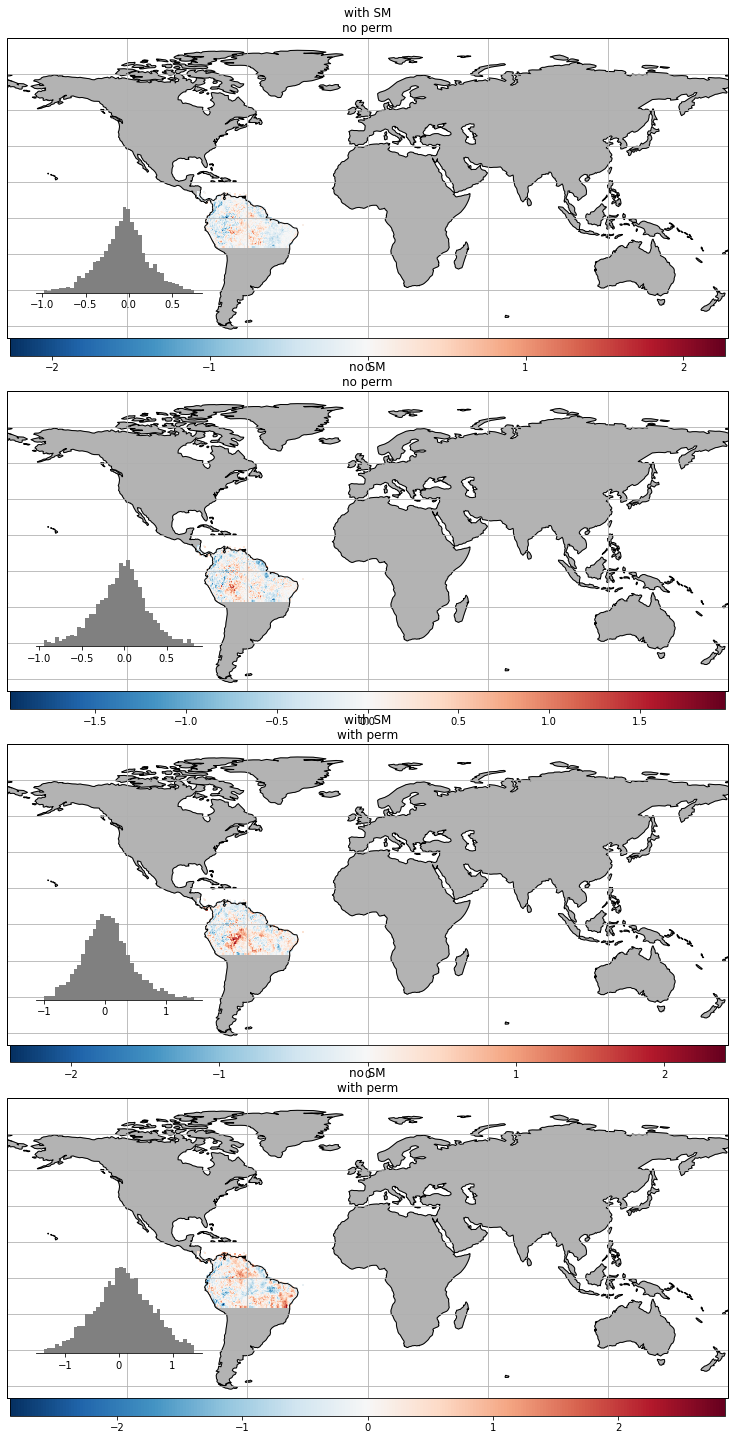

In [9]:
# Plot difference maps
fig, axes = subplots_plateCarree(4,1, figsize=(16, 26), gridspec_kw={'hspace': 0.0, 'wspace': 0})

for i, (ds, title) in enumerate(zip([diff_obs_wn, diff_obs_nn, diff_obs_ww , diff_obs_nw], ['with SM\nno perm', 'no SM\nno perm', 'with SM\nwith perm', 'no SM\nwith perm'])):
    ax = axes[i]
    plot_map(ds, ax=ax)
    ax.set_title(title)
plt.savefig('/workspace/bkraft/dl_chapter14/src/notebooks/exp2_figures/fig5.png', dpi=300)

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(5, 5))



## Scatterplot LSTM vs MATSIRO annual anomalies

/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.p

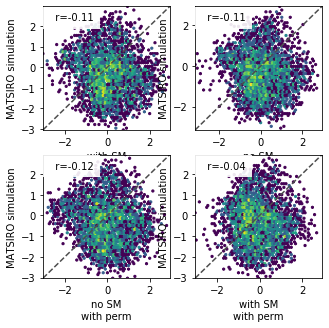

In [236]:
fig, ax = plt.subplots(2, 2, figsize=(5, 5))
plot_hexbin(amazon_raw_wn_anomaly_standarise.sel(year = 2005).mod, amazon_raw_wn_anomaly_standarise.sel(year = 2005).obs, 
           xlabel= 'with SM\nno perm', ylabel= 'MATSIRO simulation', ax=ax[0,0])
plot_hexbin(amazon_raw_nn_anomaly_standarise.sel(year = 2005).mod, amazon_raw_nn_anomaly_standarise.sel(year = 2005).obs, 
           xlabel= 'no SM\nno perm', ylabel= 'MATSIRO simulation', ax=ax[0,1])
plot_hexbin(amazon_raw_ww_anomaly_standarise.sel(year = 2005).mod, amazon_raw_nw_anomaly_standarise.sel(year = 2005).obs, 
           xlabel= 'no SM\nwith perm', ylabel= 'MATSIRO simulation', ax=ax[1,0])
plot_hexbin(amazon_raw_nw_anomaly_standarise.sel(year = 2005).mod, amazon_raw_ww_anomaly_standarise.sel(year = 2005).obs, 
           xlabel= 'with SM\nwith perm', ylabel= 'MATSIRO simulation', ax=ax[1,1])
plt.savefig('/workspace/bkraft/dl_chapter14/src/notebooks/exp2_figures/annual_anomaly_amazon_scatter.png', dpi=300)

In [259]:
def get_data(_models_dic):
    all_mod_dat={}
    _models=list(_models_dic.keys())
    mod_dat_min=[]
    mod_dat_max=[]
    mod_dat_Q95=[]
    for _md in _models:
        modInfo=_models_dic[_md]
        datfile=modInfo[0]
        datVar=modInfo[1]
        all_mod_dat[_md]=datfile
        mod_dat_min=np.append(mod_dat_min,np.nanmin(np.array(all_mod_dat[_md])))
        mod_dat_max=np.append(mod_dat_max,np.nanmax(np.array(all_mod_dat[_md])))
        mod_dat_Q95=np.append(mod_dat_Q95,np.nanpercentile(np.array(all_mod_dat[_md]),95))
    return(all_mod_dat,(np.min(mod_dat_min),np.max(mod_dat_max), np.max(mod_dat_Q95)))
dats={
'with SM\nno perm': [diff_obs_wn,"with SM\nno perm"],\
'no SM\nno perm': [diff_obs_nn,"no SM\nno perm"],\
'with SM\nwith perm': [diff_obs_ww,"with SM\nwith perm"],\
'no SM\nwith perm': [diff_obs_nw,"with SM\nwith perm"]}
models=list(dats.keys())
print(models)
nmodels=len(models)
print (dats.keys())
all_mod_dat,valrange=get_data(dats)
print(all_mod_dat.keys())
valrange_map=(0,valrange[2])
valrange_scatter=(0,valrange[1])
print(models,valrange)

fig=plt.figure(figsize=(9,6))
for row_m in range(nmodels):
    row_mod=models[row_m]
    print(row_mod,all_mod_dat.keys())
    mod_dat_row=all_mod_dat[row_mod]
    for col_m in range(nmodels):
        col_mod=models[col_m]
        mod_dat_col=all_mod_dat[col_mod]#[_which_st].mean(0))

        print('---- the model '+row_mod+' is done for variable '+col_mod+'---------')
        if row_m == col_m:
            _ax=plt.axes([x0+row_m*wp+row_m*xsp,y0-(col_m*hp+col_m*ysp),wp,hp])#,sharex=right,sharey=all)
            _mp=mtool.def_map_cyl(lonmin=-180,lonmax=180,latmin=-90,latmax=90,line_w=0.15,min_coast=True)
            _mp._ax=_ax
            print ('yo kera',valrange)
            _bounds_dia=np.linspace(min(valrange_map),max(valrange_map),100)


            cbName=varibs_info[plotVar][-1]
            clist_=mtool.get_colomap(cbName,_bounds_dia,lowp=0.13,hip=0.95)
            cm_dia = mpl.colors.ListedColormap(clist_)
            #gl_mean=np.nansum(mod_dat_row.filled(0)*area_dat)/1e12
            #print('gulo',gl_mean)
            _mp.imshow(np.ma.masked_less(mod_dat_row, -999),interpolation=None,vmin=valrange_map[0],vmax=valrange_map[1],cmap=cm_dia,origin='upper')
            print(mod_dat_row)
            #tit_str="$cVeg_{gl}$ = "+str(round(gl_mean,2))+' ($\\mathrm{pgC}$)'
            #plt.text(0,-65,tit_str,fontsize=ax_fs*0.739,ha='center')
        if row_m < col_m:
            _ax=plt.axes([x0+row_m*wp+row_m*xsp+xsp_sca,y0-(col_m*hp+col_m*ysp)+ysp_sca,wp*aspect_data,hp*aspect_data])#,sharex=right,sharey=all)
            _ax.hexbin(np.ma.masked_less(mod_dat_col, -999).flatten(), np.ma.masked_less(mod_dat_row, -9999).flatten(),bins='log',mincnt=2, gridsize=50, cmap='gist_gray_r',linewidths=0)
            plt.ylim(valrange_scatter[0],valrange_scatter[1]*1.05)
            plt.xlim(valrange_scatter[0],valrange_scatter[1]*1.05)
            ymin,ymax = plt.ylim()
            xmin,xmax = plt.xlim()
            plt.plot((xmin,xmax),(ymin,ymax),'k',lw=0.1)
            r,p=sttool.calc_spearman_r(mod_dat_col, mod_dat_row)
            mean_bias=sttool.calc_mean_relative_bias(mod_dat_col, mod_dat_row)
            gl_bias=sttool.calc_global_relative_bias(mod_dat_col, mod_dat_row)
            tit_str="r="+str(round(r,2))+"\nRB: $m$="+str(round(mean_bias,2))+", $gl$="+str(round(gl_bias,2))
            plt.title(tit_str,fontsize=ax_fs*1.2,ma='left',y=1.175,va="top")
            print (tit_str)
            if row_m !=0 and col_m != nmodels-1:
                ptool.ax_clr(axfs=1.2 *ax_fs)
            elif row_m == 0 and col_m != nmodels-1:
                ptool.ax_clrX(axfs=1.2 *ax_fs)
            elif col_m == nmodels-1 and row_m !=0 :
                ptool.ax_clrY(axfs=1.2 *ax_fs)
            if row_m == 0 and col_m == nmodels-1:
                ptool.ax_orig(axfs=1.2 *ax_fs)
                plt.ylabel('Column',fontsize=1.4 *ax_fs)
                plt.xlabel('Row',fontsize=1.4 *ax_fs)
                print('kerajasto')
        if row_m > col_m:
            _ax=plt.axes([x0+row_m*wp+row_m*xsp,y0-(col_m*hp+col_m*ysp),wp,hp])#,sharex=right,sharey=all)
            _mp=mtool.def_map_cyl(lonmin=-180,lonmax=180,latmin=-90,latmax=90,line_w=0.1,min_coast=True)
            _mp._ax=_ax
            plot_dat=  np.ma.masked_where(np.isnan(veg_mask["veg_mask"]), mod_dat_row - mod_dat_col)
            _bounds_rat=np.linspace(np.nanpercentile(plot_dat, 5),np.nanpercentile(plot_dat, 95),100)
            clist_=mtool.get_colomap('Reds_r',_bounds_dia)
            cm_rat = mpl.colors.ListedColormap(clist_) 
            _mp.imshow(plot_dat, interpolation=None, vmin=np.min(_bounds_rat), vmax=np.max(_bounds_rat), cmap=cm_rat,origin='upper')
            #_mp.imshow(np.ma.masked_less(plot_dat,-999.),interpolation=None,vmin=0,vmax=2,cmap=cm_rat,origin='upper')
        if row_m == nmodels-1:
            _title_sp=dats[col_mod][2]
            plt.ylabel(_title_sp,fontsize=1.4*ax_fs)
            plt.gca().yaxis.set_label_position("right")
        if col_m == 0:
            _title_sp=dats[row_mod][2]
            plt.title(_title_sp,fontsize=1.4*ax_fs)

t_x=plt.figtext(x0+(nmodels+1)*wp,y0+(nmodels+1)*hp,' ',transform=plt.gca().transAxes)
x_colo=((x0+x0+row_m*wp+row_m*xsp+wp)/2)-cb_off_x
x_colo=0.05#((x0+x0+row_m*wp+row_m*xsp+wp)/2)-cb_off_x
y_colo=y0+hp+cb_off_y
_axcol_dia=[x_colo,y_colo,wcolo,hcolo]
print (x_colo)
cb_tit=varibs_info[plotVar][0]+' '+varibs_info[plotVar][1]+''
mtool.mk_colo_cont(_axcol_dia,_bounds_dia,cm_dia,cbfs=0.9*ax_fs,cbtitle=cb_tit,cbrt=90)
cb_tit='Difference (Column - Row)'
x_colo=((x0+x0+row_m*wp+row_m*xsp)/2)+cb_off_x
x_colo=0.80#((x0+x0+row_m*wp+row_m*xsp+wp)/2)-cb_off_x
y_colo=y0+hp+cb_off_y
_axcol_dia=[x_colo,y_colo,wcolo,hcolo]
mtool.mk_colo_cont(_axcol_dia,_bounds_rat,cm_rat,cbfs=0.9*ax_fs,cbrt=90,cbtitle=cb_tit)
plt.savefig('/workspace/bkraft/dl_chapter14/src/notebooks/exp2_figures/annual_anomaly_amazon_map.png', dpi=300)

['with SM\nno perm', 'no SM\nno perm', 'with SM\nwith perm', 'no SM\nwith perm']
dict_keys(['with SM\nno perm', 'no SM\nno perm', 'with SM\nwith perm', 'no SM\nwith perm'])


/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.p

dict_keys(['with SM\nno perm', 'no SM\nno perm', 'with SM\nwith perm', 'no SM\nwith perm'])
['with SM\nno perm', 'no SM\nno perm', 'with SM\nwith perm', 'no SM\nwith perm'] (-2.8504773011683495, 2.433475276273371, 1.019295903723311)


In [257]:
get_data(dats)

['with SM\nno perm', 'no SM\nno perm', 'with SM\nwith perm', 'no SM\nwith perm']


/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.p

({'with SM\nno perm': <xarray.DataArray (lat: 56, lon: 108)>
  dask.array<sub, shape=(56, 108), dtype=float64, chunksize=(15, 15), chunktype=numpy.ndarray>
  Coordinates:
    * lat      (lat) float64 12.75 12.25 11.75 11.25 ... -13.75 -14.25 -14.75
    * lon      (lon) float64 -84.75 -84.25 -83.75 -83.25 ... -32.25 -31.75 -31.25
      year     int64 2005,
  'no SM\nno perm': <xarray.DataArray (lat: 56, lon: 108)>
  dask.array<sub, shape=(56, 108), dtype=float64, chunksize=(15, 15), chunktype=numpy.ndarray>
  Coordinates:
    * lat      (lat) float64 12.75 12.25 11.75 11.25 ... -13.75 -14.25 -14.75
    * lon      (lon) float64 -84.75 -84.25 -83.75 -83.25 ... -32.25 -31.75 -31.25
      year     int64 2005,
  'with SM\nwith perm': <xarray.DataArray (lat: 56, lon: 108)>
  dask.array<sub, shape=(56, 108), dtype=float64, chunksize=(15, 15), chunktype=numpy.ndarray>
  Coordinates:
    * lat      (lat) float64 12.75 12.25 11.75 11.25 ... -13.75 -14.25 -14.75
    * lon      (lon) float64 -84.75

'with SM\nno perm'